### Imports

In [29]:
import os

from sklearn.ensemble import RandomForestClassifier

import sklearn
import pickle


In [30]:
from common.libs.data_analysis.SeriesDescriberWRTTarget import *
from common.libs.PandasHelper import *
from common.libs.data_analysis.SeriesDescriber import *

### Science stuff

#### Describe DF

In [31]:
pd.read_csv("./inputs/train.csv").head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


In [32]:
pd.read_csv("./inputs/train.csv").info(show_counts=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


#### Describe columns

In [33]:
df_to_analyse: pd.DataFrame = pd.read_csv("./inputs/train.csv")

In [34]:
summarize_categorical_columns_wrt_target(df_to_analyse, 'Pclass', 'Survived')

,Pclass,count,mean,sum
0,1,216,0.629630,136
1,2,184,0.472826,87
2,3,491,0.242363,119


In [35]:
tmp_df = pd.DataFrame(apply_regex(df_to_analyse["Cabin"], '([A-Za-z]+)'), columns=["Cabin"])
tmp_df["Survived"] = df_to_analyse["Survived"]
tmp_df.dropna(subset=["Cabin"], inplace=True)

summarize_categorical_columns_wrt_target(tmp_df, 'Cabin', 'Survived')

,Cabin,count,mean,sum
0,A,15,0.466667,7
1,B,47,0.744681,35
2,C,59,0.593220,35
3,D,33,0.757576,25
4,E,32,0.750000,24
5,F,13,0.615385,8
6,G,4,0.500000,2
7,T,1,0.000000,0


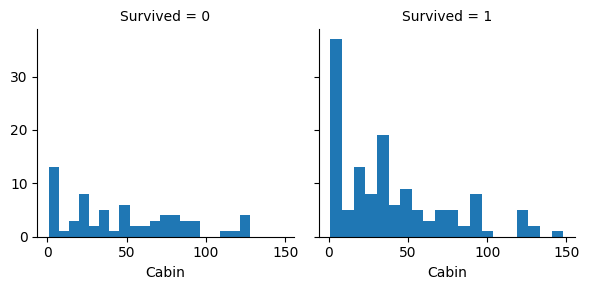

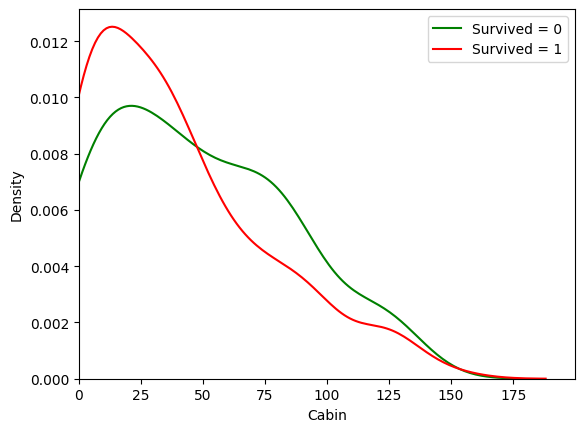

In [36]:
tmp_df = pd.DataFrame(apply_regex(df_to_analyse["Cabin"], '([1-9]+)'), columns=["Cabin"])
tmp_df["Survived"] = df_to_analyse["Survived"]
tmp_df.dropna(subset=["Cabin"], inplace=True)

summarize_continuous_columns_wrt_target(tmp_df.astype(int), 'Cabin', 'Survived')
show_distribution(tmp_df.astype(int), "Cabin", "Survived")

In [37]:
summarize_categorical_columns_wrt_target(df_to_analyse, 'Sex', 'Survived')

,Sex,count,mean,sum
0,female,314,0.742038,233
1,male,577,0.188908,109


In [38]:
summarize_categorical_columns_wrt_target(df_to_analyse, 'Embarked', 'Survived')

,Embarked,count,mean,sum
0,C,168,0.553571,93
1,Q,77,0.389610,30
2,S,644,0.336957,217


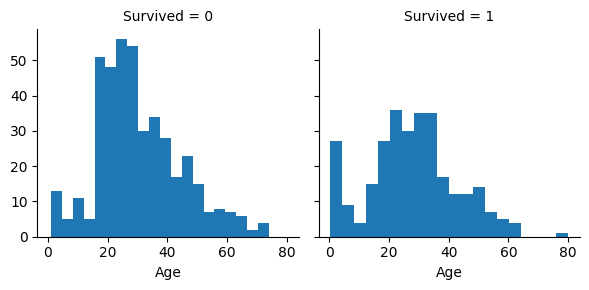

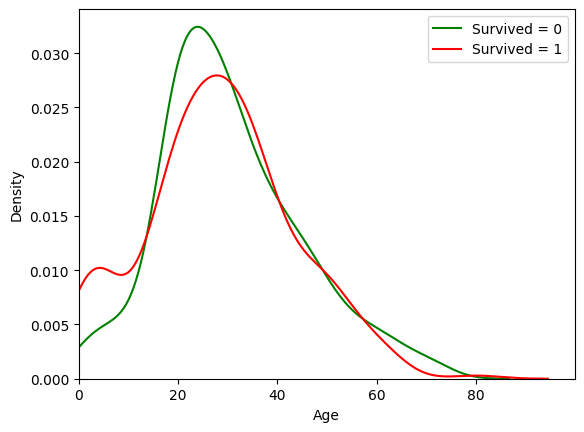

In [39]:
summarize_continuous_columns_wrt_target(df_to_analyse, 'Age', 'Survived')

show_distribution(df_to_analyse, "Age", "Survived")


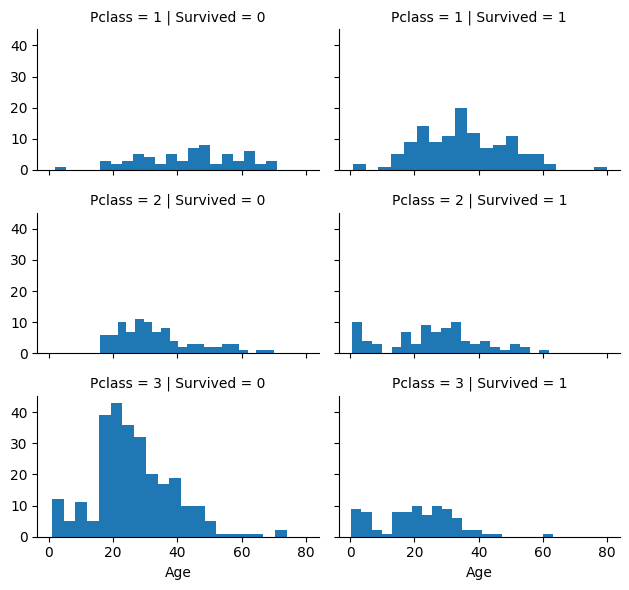

In [40]:
summarize_continuous_columns_wrt_target(df_to_analyse, 'Age', 'Survived', row='Pclass')

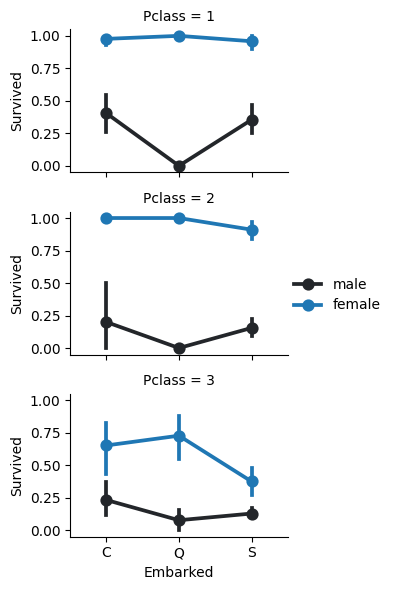

In [41]:
g = sns.FacetGrid(df_to_analyse, row='Pclass', height=2, aspect=1.6)
g.map(sns.pointplot,
      'Embarked',
      'Survived',
      'Sex',
      hue_order=['male', 'female'],
      order=['C', 'Q', 'S'],
      palette='dark:#1f77b4')
g.add_legend()
plt.show()

,Fare
count,891.000000
mean,32.204208
std,49.693429
min,0.000000
25%,7.910400
50%,14.454200
75%,31.000000
max,512.329200
,count
"(-0.513, 51.233]",732


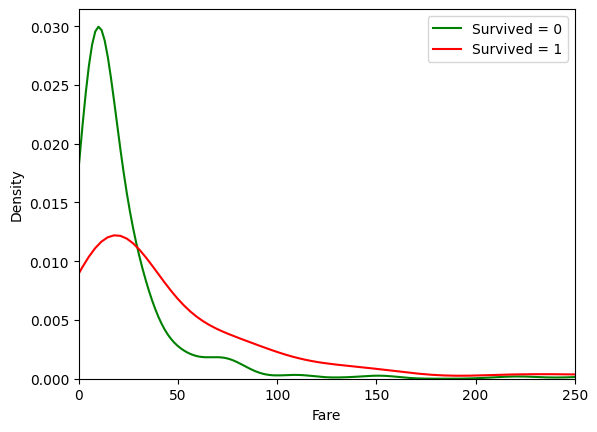

In [42]:
describe_continuous_series(df_to_analyse['Fare'])

show_distribution(df_to_analyse, "Fare", "Survived", max_x=250)


In [43]:
titles_mapping = {
    "Mr": "Mr",
    "Capt": "Mr",
    "Col": "Mr",
    "Major": "Mr",
    "Dr": "Mr",
    "Rev": "Mr",
    "Jonkheer": "Mr",
    "Don": "Mr",
    "Sir": "Mr",
    "Mme": "Mrs",
    "Mrs": "Mrs",
    "Countess": "Mrs",
    "Dona": "Mrs",
    "Lady": "Mrs",
    "Master": "Master",
    "Ms": "Miss",
    "Mlle": "Miss",
    "Miss": "Miss",
}

tmp_df = apply_regex(df_to_analyse["Name"], " ([A-Za-z]+)\\.").map(titles_mapping).to_frame()

describe_categorical_series(
        tmp_df
)

tmp_df["Survived"] = df_to_analyse["Survived"]

summarize_categorical_columns_wrt_target(tmp_df, 'Name', 'Survived')

summarize_categorical_columns_wrt_target(df_to_analyse, 'Sex', 'Survived')

,Name
count,891
unique,4
top,Mr
freq,538
,count
Name,
Mr,538
Miss,185
Mrs,128
Master,40


,Name,count,mean,sum
0,Master,40,0.575000,23
1,Miss,185,0.702703,130
2,Mr,538,0.161710,87
3,Mrs,128,0.796875,102


,Sex,count,mean,sum
0,female,314,0.742038,233
1,male,577,0.188908,109


### Processing DF

In [44]:
titles_mapping = {
    "Mr": "Mr",
    "Capt": "Mr",
    "Col": "Mr",
    "Major": "Mr",
    "Dr": "Mr",
    "Rev": "Mr",
    "Jonkheer": "Mr",
    "Don": "Mr",
    "Sir": "Mr",
    "Mme": "Mrs",
    "Mrs": "Mrs",
    "Countess": "Mrs",
    "Dona": "Mrs",
    "Lady": "Mrs",
    "Master": "Master",
    "Ms": "Miss",
    "Mlle": "Miss",
    "Miss": "Miss",
}


def process_df(df: pd.DataFrame) -> pd.DataFrame:
    # Title extraction
    df["Title"] = apply_regex(df["Name"], " ([A-Za-z]+)\\.").map(titles_mapping)

    # Deal with cabin
    df["Deck"] = apply_regex(df["Cabin"], '([A-Za-z]+)')

    # Deal with sex
    sex_map = {"male": 0, "female": 1}
    df["Sex"] = df["Sex"].map(sex_map)

    # Deal with N/A
    df["Deck"] = df["Deck"].fillna("N/A")
    df["Embarked"] = df["Embarked"].fillna(df["Embarked"].mode())
    df["Age"] = df["Age"].fillna(df["Age"].mean())

    # Add more features
    # df["Family Members"] = df["SibSp"] + df["Parch"]

    # Drop useless features
    df.drop(columns=["Name", "Ticket", "Cabin"], inplace=True)

    # Set index
    df.set_index("PassengerId", inplace=True)

    # One-hot encode
    categorical_columns = ["Embarked", "Deck", "Title"]
    return one_hot_encode(df, categorical_columns)



In [45]:
# Import DF
train_val_df: pd.DataFrame = pd.read_csv("./inputs/train.csv")
test_df: pd.DataFrame = pd.read_csv("./inputs/test.csv")

index = train_val_df.shape[0]
total = process_df(pd.concat([train_val_df, test_df], ignore_index=True))

train_val_df = total.iloc[:index]
test_df = total.iloc[index:]

test_df.tail()

,Survived,Pclass,Sex,Age,SibSp,Parch,Fare,Family Members,Embarked_C,Embarked_Q,...,Deck_D,Deck_E,Deck_F,Deck_G,Deck_N/A,Deck_T,Title_Master,Title_Miss,Title_Mr,Title_Mrs
PassengerId,,,,,,,,,,,,,,,,,,,,,
1305,NaN,3,0,29.881138,0,0,8.0500,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1306,NaN,1,1,39.000000,0,0,108.9000,0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1307,NaN,3,0,38.500000,0,0,7.2500,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1308,NaN,3,0,29.881138,0,0,8.0500,0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1309,NaN,3,0,29.881138,1,1,22.3583,2,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [46]:
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 891 entries, 1 to 891
Data columns (total 25 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Survived        891 non-null    float64
 1   Pclass          891 non-null    int64  
 2   Sex             891 non-null    int64  
 3   Age             891 non-null    float64
 4   SibSp           891 non-null    int64  
 5   Parch           891 non-null    int64  
 6   Fare            891 non-null    float64
 7   Family Members  891 non-null    int64  
 8   Embarked_C      891 non-null    float64
 9   Embarked_Q      891 non-null    float64
 10  Embarked_S      891 non-null    float64
 11  Embarked_nan    891 non-null    float64
 12  Deck_A          891 non-null    float64
 13  Deck_B          891 non-null    float64
 14  Deck_C          891 non-null    float64
 15  Deck_D          891 non-null    float64
 16  Deck_E          891 non-null    float64
 17  Deck_F          891 non-null    float64


### Testing Model

In [47]:
def test_random_forest(x, y, x_val, y_val, **kwargs):
    tmp_model = get_model(x, y, **kwargs)
    pred = tmp_model.predict(x_val)
    return compare(pred, y_val)


def get_model(x, y, **kwargs):
    tmp_model = RandomForestClassifier(**kwargs)
    tmp_model.fit(x, y)
    return tmp_model


def compare(pred, y):
    return np.count_nonzero(y.to_numpy() == pred) / len(y)

#### Hyperparameter Tuning

In [48]:
# Finding the best hyperparameters by averaging performance based on cross validation
FILE_LOC = "./saved/calculated.pkl"

n_estimators_s = range(50, 400, 50)
max_depth_s = range(1, 10)

results = pickle.load(open(FILE_LOC, 'rb')) if os.path.exists(FILE_LOC) else {}

kf = sklearn.model_selection.KFold(random_state=42, n_splits=5, shuffle=True)

for n_estimators in n_estimators_s:
    for max_depth in max_depth_s:
        if results.get((n_estimators, max_depth)) is not None:
            print(f"Skipping {n_estimators} {max_depth} {results.get((n_estimators, max_depth))}")
            continue

        average = []
        for train_index, val_index in kf.split(train_val_df):
            train_df = train_val_df.iloc[train_index]
            val_df = train_val_df.iloc[val_index]

            train_y = train_df["Survived"]
            train_x = train_df.drop("Survived", axis=1)

            val_y = val_df["Survived"]
            val_x = val_df.drop("Survived", axis=1)

            average.append(test_random_forest(train_x,
                                              train_y,
                                              val_x,
                                              val_y,
                                              n_estimators=n_estimators,
                                              random_state=1,
                                              max_depth=max_depth))
        print(n_estimators, max_depth, np.mean(average), sep="\t")
        results[(n_estimators, max_depth)] = np.mean(average)

with open(FILE_LOC, 'wb') as file:
    pickle.dump(results, file)

Skipping 50 1 0.7789341535371289
Skipping 50 2 0.7979850605737242
Skipping 50 3 0.8092084614901764
Skipping 50 4 0.8249387985688281
Skipping 50 5 0.8316740945326722
Skipping 50 6 0.8417676228736426
Skipping 50 7 0.8294080723118448
Skipping 50 8 0.8283033080158182
Skipping 50 9 0.8316740945326722
Skipping 100 1 0.7755570899504113
Skipping 100 2 0.7979850605737242
Skipping 100 3 0.8092084614901764
Skipping 100 4 0.826062394074446
Skipping 100 5 0.8327851358985626
Skipping 100 6 0.8372669637813068
Skipping 100 7 0.8383905592869247
Skipping 100 8 0.8294269035214361
Skipping 100 9 0.8305379448873266
Skipping 150 1 0.7778105580315109
Skipping 150 2 0.793496955621116
Skipping 150 3 0.8069612704789405
Skipping 150 4 0.8249387985688281
Skipping 150 5 0.8316678174628084
Skipping 150 6 0.838390559286925
Skipping 150 7 0.8383968363567886
Skipping 150 8 0.8282907538760907
Skipping 150 9 0.8339087314041805
Skipping 200 1 0.7733287301487666
Skipping 200 2 0.793496955621116
Skipping 200 3 0.8092147385

In [49]:
display_2d_hyperparameter_grid_search(n_estimators_s, max_depth_s, results, names=("Number of Estimators", "Max Depth"))

### Submissions

In [51]:
train_df = train_val_df  #.sample(frac=0.8, random_state=1)

train_y = train_df["Survived"]
train_x = train_df.drop("Survived", axis=1)

model = get_model(train_x, train_y, n_estimators=500, random_state=1, max_depth=7)
predictions = model.predict(test_df.drop("Survived", axis=1))

output = pd.DataFrame({'PassengerId': test_df.index, 'Survived': predictions.astype(int)})
output.to_csv('submission.csv', index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!
